**Sprawozdanie z zadania dodatkowego**
*Piotr Piotrak, 82667*

Nie jestem autorem użytego kodu oraz algorytmu. Jest on chroniony prawami autorskimi. Poniżej wstawiam źródła kodu.

Źródła:
* https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/neural_style_transfer.ipynb#scrollTo=aPycGReakDlK
* https://keras.io/examples/generative/neural_style_transfer/




Neural Style Transfer (NST) to algorytm deep learningu, który łączy obraz stylizowany w określonym stylu artystycznym z innym obrazem jako treść. Algorytm uczy się charakterystycznych cech stylistycznych z wybranego obrazu stylu i aplikuje je na inny obraz jako treść. Rezultatem jest nowy obraz, który posiada cechy stylistyczne z obrazu stylu i treść z obrazu treści.

NST działa na zasadzie optymalizacji sieci neuronowej. Sieć neuronowa jest uczona na dwóch obrazach - obrazie stylu i treści - a następnie wykorzystywana do wygenerowania nowego obrazu, który jest minimalizacją różnicy między wyjściem sieci a obrazem treści i maksymalizacją różnicy między wyjściem sieci a obrazem stylu.

Możliwości NST są nieograniczone i zależą od wybranego stylu i obrazu treści. Można wygenerować nowe obrazy w stylu tradycyjnej sztuki, abstrakcyjnej sztuki, fotografii i wielu innych. NST może być również wykorzystywany w aplikacjach takich jak retusz zdjęć, koloryzacja obrazów i generowanie nowych obrazów.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("goryy.jpg", "https://www.imperiumtapet.com/public/uploads/preview/tapety-gory-23jpg-311533416961cztjuiizhb.jpg")
style_reference_image_path = keras.utils.get_file(
    "zdjecie3.jpg", "https://st.depositphotos.com/1000423/3042/i/600/depositphotos_30424213-stock-photo-gorgeous-woman-playing-violin.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

215001/215001 [==============================] - 1s 4us/step


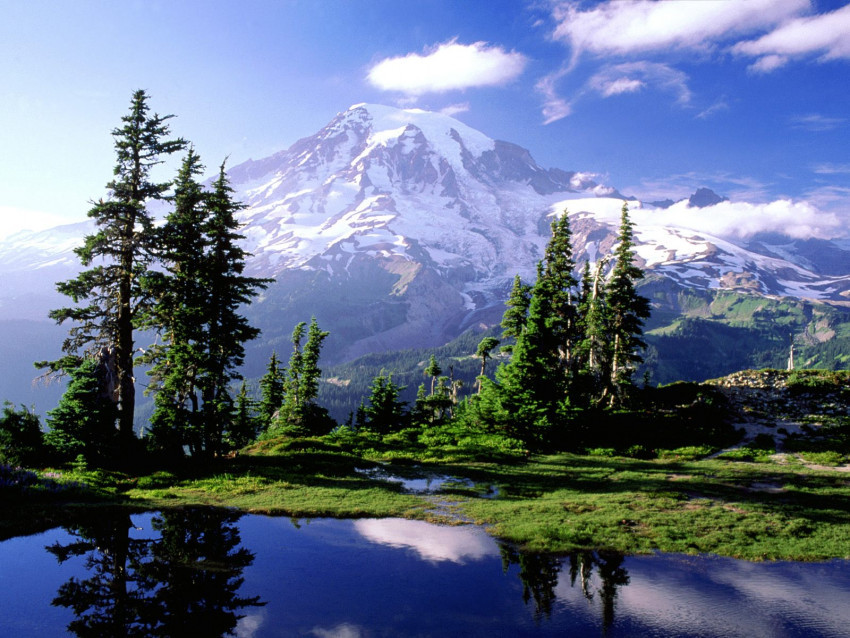

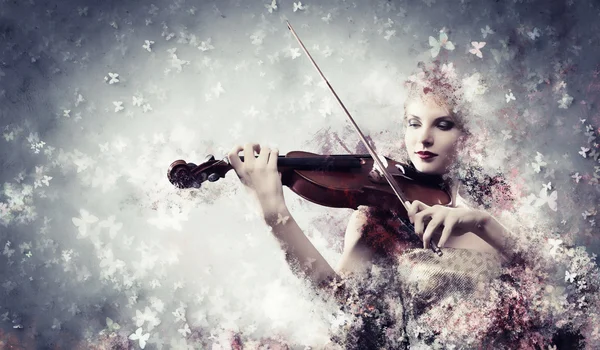

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [ ]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [ ]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


In [ ]:
import time

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 2500
suma_czas_iteracji = 0
start_time = time.time()
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
        czas_iteracji = time.time() - start_time
        suma_czas_iteracji += czas_iteracji
        print("Czas trwania iteracji: {:.2f} sekund.".format(czas_iteracji))
        start_time = time.time()

print("Wykonanie wszystkich iteracji zajęło: {:.2f} minut.".format(suma_czas_iteracji/60))

Iteration 100: loss=2156.47
Czas trwania iteracji: 31.03 sekund.
Iteration 200: loss=1422.33
Czas trwania iteracji: 25.40 sekund.
Iteration 300: loss=1161.08
Czas trwania iteracji: 25.01 sekund.
Iteration 400: loss=1027.83
Czas trwania iteracji: 25.79 sekund.
Iteration 500: loss=946.83
Czas trwania iteracji: 25.77 sekund.
Iteration 600: loss=891.80
Czas trwania iteracji: 25.35 sekund.
Iteration 700: loss=851.74
Czas trwania iteracji: 25.53 sekund.
Iteration 800: loss=821.30
Czas trwania iteracji: 25.66 sekund.
Iteration 900: loss=797.22
Czas trwania iteracji: 25.54 sekund.
Iteration 1000: loss=777.67
Czas trwania iteracji: 25.45 sekund.
Iteration 1100: loss=761.47
Czas trwania iteracji: 25.44 sekund.
Iteration 1200: loss=747.80
Czas trwania iteracji: 25.47 sekund.
Iteration 1300: loss=736.12
Czas trwania iteracji: 25.51 sekund.
Iteration 1400: loss=726.00
Czas trwania iteracji: 25.50 sekund.
Iteration 1500: loss=717.14
Czas trwania iteracji: 25.50 sekund.
Iteration 1600: loss=709.32
Cz

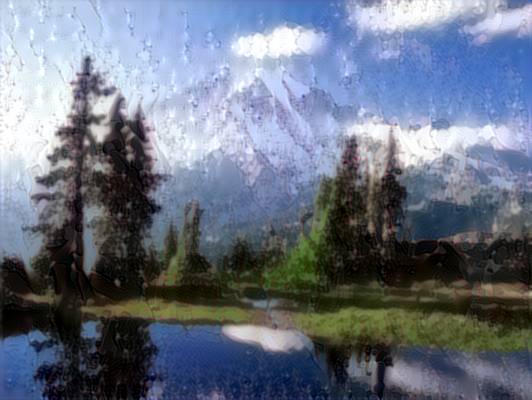

In [ ]:
display(Image(result_prefix + "_at_iteration_2500.png"))

Wykonywałem 1500, 2000 oraz 2500 iteracji ze względu na czas który zajmują iterację. Oczywiście im więcej iteracji tym lepszy efekt.

Poeksperymentowałem na trzech oddzielnych przykładach, aby sprawdzić wyniki różnych zdjęć. Myślę że efekt działania algorytmu jest bardzo zadowalający oraz bardzo przyjemny dla oka, a także ciekawie się sprawdza jak algorytm zadziała na różnych zdjęciach.

Dodalem również mierzenie czasu iteracji oraz na koniec sumę tych czasów, aby zobaczyć ile zajęło algorytmowi połączenie dwóch zdjęć.

**Neural Style Transfer (NTS) może mieć szerokie zastosowanie w praktyce, w takich dziedzinach jak:**
* Fotografia i obrazowanie: NTS może być używany do przekształcania zdjęć i obrazów w różne style artystyczne.
* Sztuka cyfrowa i animacja: NTS może być wykorzystywany do tworzenia animacji i dzieł sztuki cyfrowej o unikalnym stylu.
* Projektowanie graficzne: NTS może być stosowany do tworzenia projektów graficznych, takich jak logo i banery reklamowe.
* Reklamy i marketing: NTS może być używany do stworzenia reklam i materiałów marketingowych z unikalnym i atrakcyjnym stylem.
* Fotografia produktowa: NTS może być używany do ulepszania zdjęć produktów i zapewniania ich jednolitego stylu.

**Poniżej przedstawiam dwa dodatkowe przykłady połączenia zdjęć oraz czas wykonywania iteracji.**

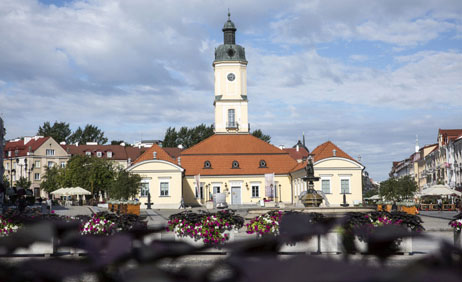



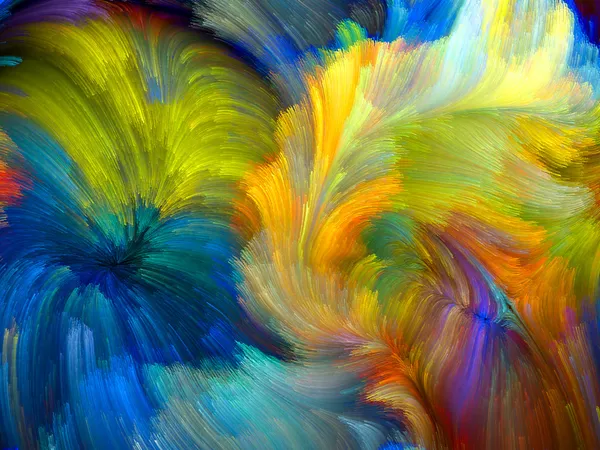

Efekt połączenia zdjęć:

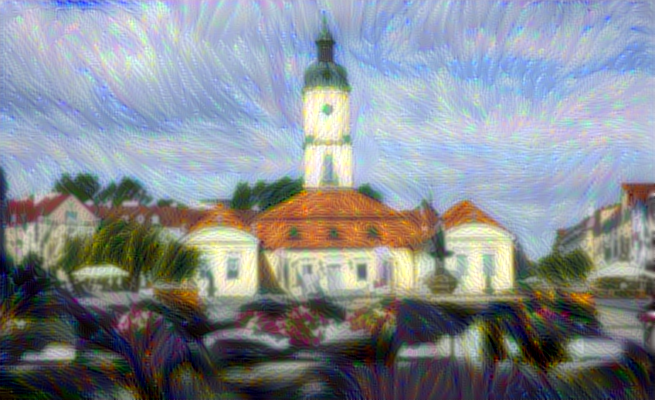

Iteration 100: loss=2812.67

Czas trwania iteracji: 39.92 sekund.

Iteration 200: loss=1989.33

Czas trwania iteracji: 28.29 sekund.

Iteration 300: loss=1649.72

Czas trwania iteracji: 28.71 sekund.

Iteration 400: loss=1462.05

Czas trwania iteracji: 29.12 sekund.

Iteration 500: loss=1342.14

Czas trwania iteracji: 29.52 sekund.

Iteration 600: loss=1258.19

Czas trwania iteracji: 29.84 sekund.

Iteration 700: loss=1195.83

Czas trwania iteracji: 30.16 sekund.

Iteration 800: loss=1147.37

Czas trwania iteracji: 30.43 sekund.

Iteration 900: loss=1108.43

Czas trwania iteracji: 30.22 sekund.

Iteration 1000: loss=1076.38

Czas trwania iteracji: 30.27 sekund.

Iteration 1100: loss=1049.35

Czas trwania iteracji: 30.37 sekund.

Iteration 1200: loss=1026.11

Czas trwania iteracji: 30.43 sekund.

Iteration 1300: loss=1005.89

Czas trwania iteracji: 30.47 sekund.

Iteration 1400: loss=988.18

Czas trwania iteracji: 30.47 sekund.

Iteration 1500: loss=972.53

Czas trwania iteracji: 30.49 sekund.

Wykonanie wszystkich iteracji zajęło: 7.64 minut.

**Kolejny przykład:**

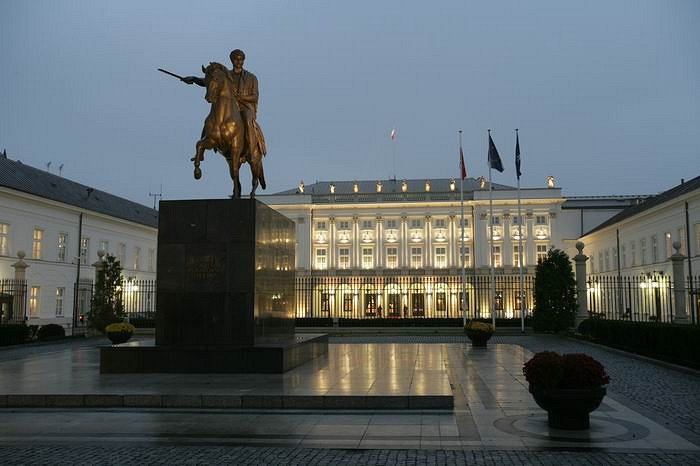

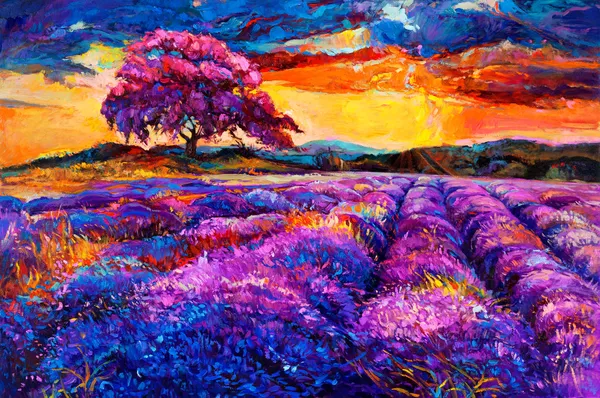

Efekt połączenia zdjęć:

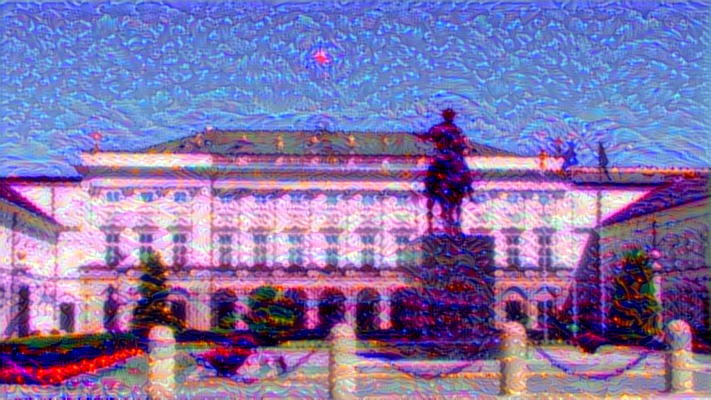

Wykonanie wszystkich iteracji zajęło: 11.15 minut.